In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px

In [4]:
file = "bayc_cleaned.csv"
df = pd.read_csv(f"data/{file}", index_col=0)

In [5]:
# summary statistics
df.describe()

,token_id,amount_usd,trade_price,volume_eth,price_p5_eth,price_min_eth,price_max_eth,last_trade_price,last_trade_timediff,volume_eth_lag1,...,price_min_eth_lag1,trade_price_log,rarity_rank,Background_count,Hat_count,Mouth_count,Eyes_count,Fur_count,Clothes_count,Earring_count
count,43383.000000,4.338300e+04,4.338300e+04,43383.000000,43383.000000,4.338300e+04,43383.000000,3.434400e+04,34344.000000,43383.000000,...,4.338300e+04,43383.000000,43383.000000,43383.000000,43383.000000,43383.000000,43383.000000,43383.000000,43383.000000,43383.000000
mean,5115.788281,8.054898e+04,3.579681e+01,2548.761859,30.108027,2.661146e+01,83.208344,3.188095e+01,70.638327,2010.472928,...,2.721597e+01,2.435174,5415.465067,1251.249245,683.358712,1003.657700,695.033953,868.864901,491.120762,4847.956942
std,2854.394833,1.042743e+05,4.009933e+01,3059.347312,30.579961,2.949609e+01,111.699179,3.428294e+01,146.547847,2430.336042,...,2.980327e+01,2.018350,2731.909206,35.161549,748.589743,827.757801,472.495709,414.505119,570.647304,2531.490796
min,5.000000,1.891200e-15,1.000000e-18,13.795900,0.000002,1.000000e-18,0.850000,1.000000e-18,0.000000,0.160000,...,1.000000e-18,-41.446532,3.000000,1170.000000,65.000000,26.000000,49.000000,46.000000,42.000000,149.000000
25%,2733.000000,5.367239e+03,2.000000e+00,676.827431,1.390000,3.200000e-01,21.000000,1.900000e+00,0.650694,560.845702,...,3.200000e-01,0.693147,3215.000000,1242.000000,223.000000,266.000000,394.000000,496.000000,202.000000,882.000000
50%,5105.000000,5.748591e+04,2.910000e+01,1423.937325,26.290000,1.733333e+01,50.500000,2.661000e+01,8.551944,1262.750000,...,1.841210e+01,3.370738,5577.000000,1266.000000,318.000000,710.000000,549.000000,778.000000,235.000000,6383.000000
75%,7583.000000,1.086708e+05,5.800000e+01,3061.237641,48.770000,4.550010e+01,100.000000,5.000000e+01,56.764589,2633.580000,...,4.599000e+01,4.060443,7741.000000,1283.000000,578.000000,1551.000000,751.000000,1352.000000,334.000000,6383.000000
max,9998.000000,2.911656e+06,1.024000e+03,17273.253910,149.000000,1.390000e+02,1080.690000,7.800000e+02,873.294201,17273.253910,...,1.390000e+02,6.931472,9998.000000,1291.000000,2042.000000,2272.000000,1714.000000,1370.000000,1690.000000,6383.000000


In [6]:
df['block_date'] = pd.to_datetime(df['block_date'])
df['block_date'] = df['block_date'].dt.date

# Price by date

In [36]:
import plotly.graph_objs as go

mean_prices = df.groupby('block_date').trade_price.mean().reset_index()
mean_prices.columns = ['block_date', 'mean_trade_price']
go.Scatter()
fig = go.Figure(
    data = [
        go.Scatter(
            mode='markers',
            x=df["block_date"], 
            y=df["trade_price"], 
            name='Individual Trade',
        ),
        go.Scatter(
            mode='lines', 
            x=mean_prices.block_date, 
            y=mean_prices.mean_trade_price, 
            name='Average Trade Price', 
            line=dict(color='red', width=2)
        )
    ],
    layout = go.Layout(
        xaxis=dict(title='Date'),
        yaxis=dict(title='Trade Price (ETH)'),
        legend=dict(
        x=1,
        y=1,
        xanchor='auto',
        yanchor='auto'
    )
    )
)

fig.show()

In [35]:
# plot mean price by rarity rank in batches of 20 e.g. rank 1-20, 21-40, etc.
rarity_rank = df.groupby('rarity_rank').trade_price.mean().reset_index()
rarity_rank.columns = ['rarity_rank', 'mean_trade_price']
rarity_rank['rarity_rank'] = rarity_rank['rarity_rank'].apply(lambda x: x//100)
rarity_rank = rarity_rank.groupby('rarity_rank').mean().reset_index()
rarity_rank['rarity_rank'] = rarity_rank['rarity_rank'].astype(int)*100

fig2 = go.Figure(
    data = [
        go.Bar(
            x=rarity_rank.rarity_rank, 
            y=rarity_rank.mean_trade_price, 
            name='Average Trade Price'
        )
    ],
    # label ticks with rarity rank, showing only every 100th rank
    layout = go.Layout(
        xaxis=dict(title='Rarity Rank (#)', dtick=1000),
        yaxis=dict(title='Trade Price (ETH)'),
    
    )
)

fig2.show()

# PCA Analysis

In [37]:
# define column sets
feature_columns = {
    "market" : ['volume_eth', 'price_p5_eth_lag1', 'price_max_eth_lag1', 'price_min_eth_lag1'],
    "traits_rarity" : ['rarity_rank', 'Background_count', 'Mouth_count', 'Eyes_count', 'Fur_count', 'Hat_count', 'Clothes_count', 'Earring_count'],
    "last_trade" : ['last_trade_timediff', 'last_trade_price'],
}

outcome_columns = {
    'trade_price' : 'trade_price',
    'amount_usd' : 'amount_usd',
    'trade_price_log' : 'trade_price_log'
}

In [38]:
def df_to_xy(df, X_cols, y_col):
    
    # fetch variables of interest, drop missing values
    data = df.copy()
    n = len(data)
    data = data.dropna(subset=X_cols+[y_col])
    print(f"Number of observations: {len(data)}/{n}")
    
    X = data[X_cols]
    y = data[y_col]
    
    return X, y

In [39]:
# PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def feature_PCA(df, X_cols, y_col, plot=False):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ])

    X,y = df_to_xy(df,X_cols,y_col)

    X_PCA = pipe.fit_transform(X)

    if plot:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y)
        ax.set_xlabel("PCA0")
        ax.set_ylabel("PCA1")
        ax.set_zlabel("PCA2")
        ax.set_title("PCA space")
        plt.show()

    return X_PCA

In [40]:
# model 1
X_cols_1 = feature_columns['market'] + feature_columns['traits_rarity'] + feature_columns['last_trade']
X_cols_2 = feature_columns['market'] + feature_columns['traits_rarity']
X_cols_3 = feature_columns['traits_rarity'] + feature_columns['last_trade']

y_col_1 = "trade_price"
y_col_2 = "trade_price_log"
y_col_3 = "amount_usd"

Number of observations: 34344/43383


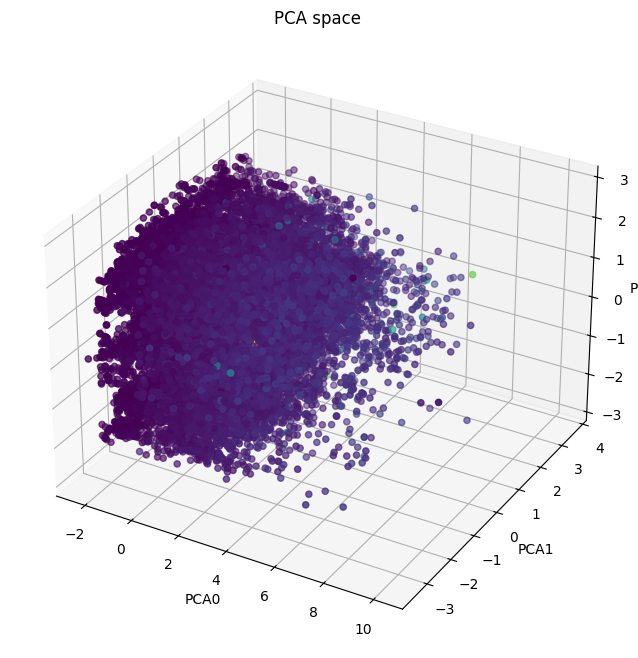

In [56]:
XPCA = feature_PCA(df, X_cols_1, y_col_1, plot=True)

Number of observations: 34344/43383


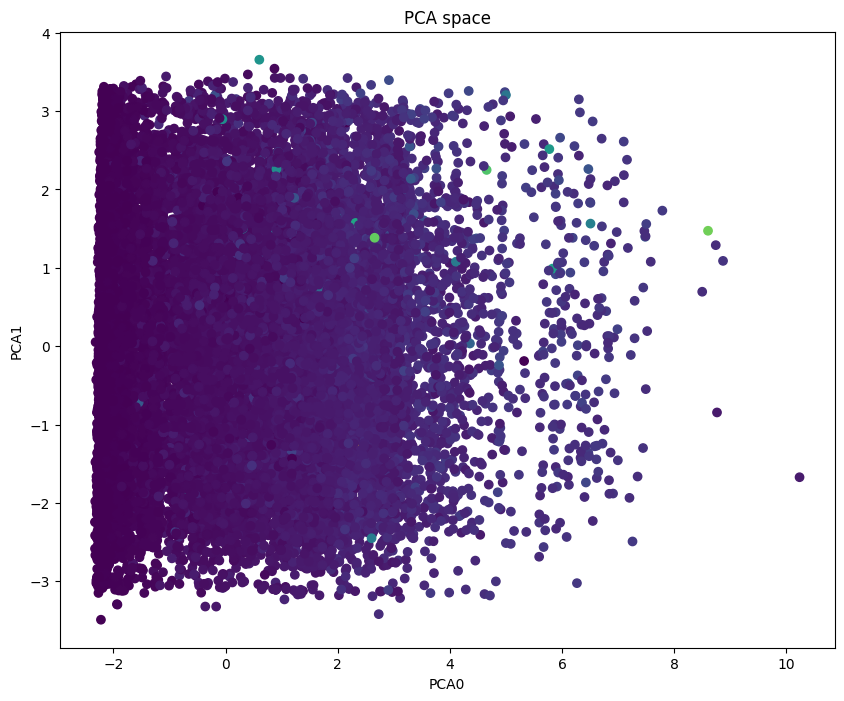

In [55]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

X,y = df_to_xy(df,X_cols_1,y_col_1)

X_PCA = pipe.fit_transform(X)

# 2d plot PCA
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.scatter(X_PCA[:,0], X_PCA[:,1], c=y)
ax.set_xlabel("PCA0")
ax.set_ylabel("PCA1")
ax.set_title("PCA space")
plt.show()